# **Phát hiện giới tính**
## Tổng quan dữ liệu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

In [2]:
import os
note_path = os.getcwd()

traindir = os.path.join(note_path,'Training')
validdir = os.path.join(note_path,'Validation')

os.listdir(traindir)

['female', 'male']

In [5]:
from tensorflow.keras.preprocessing.image import load_img

def show_img(dir):
    plt.figure(figsize=(12,7))
    for i in range(10):
        plt.subplot(2,5,i+1) #Chia figure thành 2 hàng, 5 cột
        
        img = random.choice(os.listdir(dir))
        img = load_img(os.path.join(dir,img)) #tải ảnh lên
        plt.subplots_adjust(hspace=0.2)
        x = dir.split("//")[-1] #Lấy tên thư mục (male/female)
        if x == 'male':
            plt.suptitle("Male Images", fontsize=15)
        else:
            plt.suptitle("Female Images", fontsize=15)
        
        plt.imshow(img)
    plt.tight_layout() #điều chỉnh bố cục

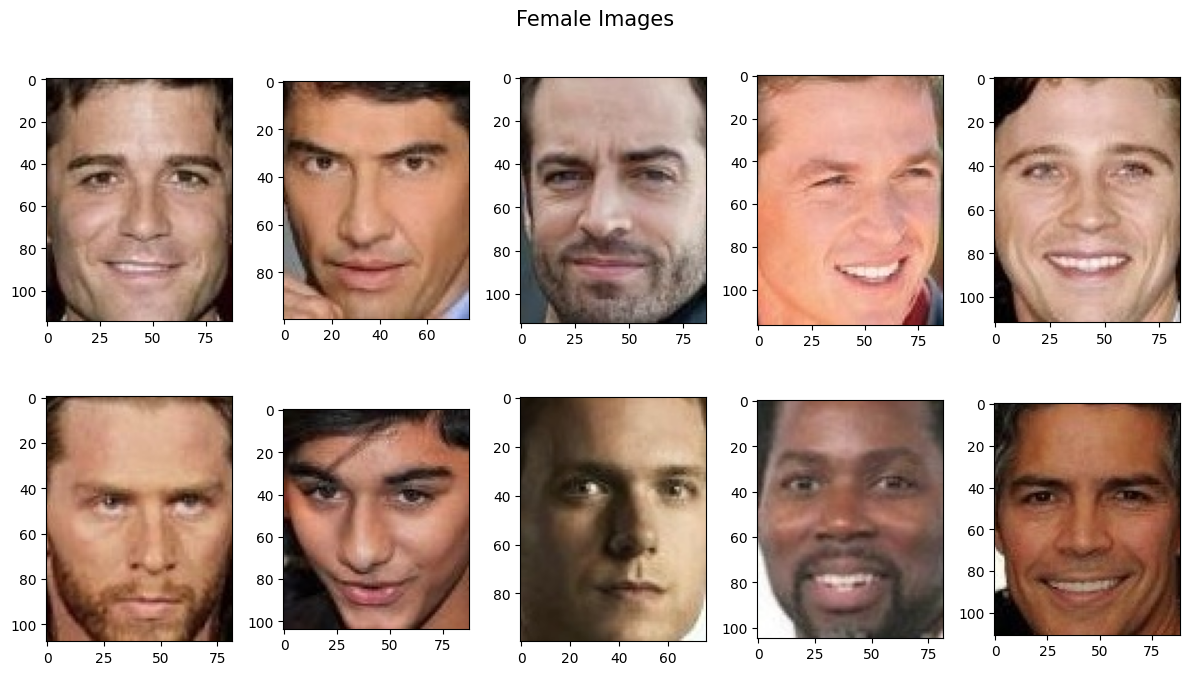

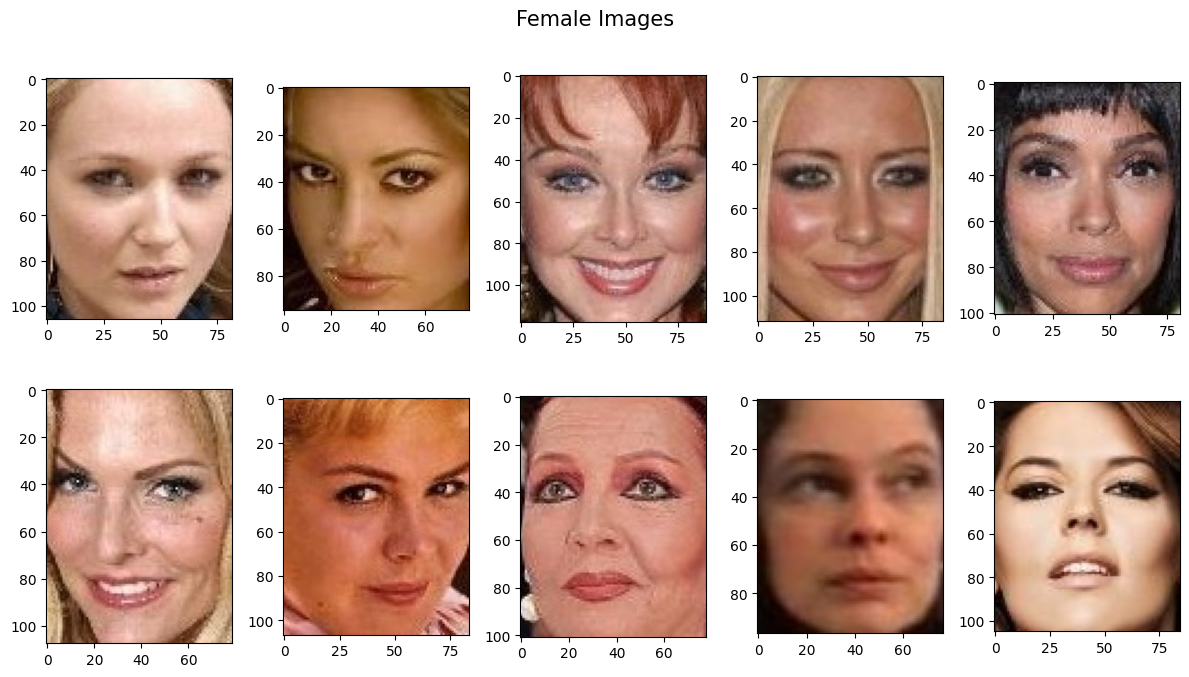

In [6]:
folder_names = ['male', 'female']
for name in folder_names:
    show_img(os.path.join(traindir, name))

In [7]:
for name in folder_names:
    print(f'{name}:')
    count = len(os.listdir(os.path.join(traindir,name)))
    print(f'\tTraining directory contains {count} images')
    count = len(os.listdir(os.path.join(validdir,name)))
    print(f'\tValidation directory contains {count} images')

male:
	Training directory contains 23766 images
	Validation directory contains 5808 images
female:
	Training directory contains 23243 images
	Validation directory contains 5841 images


**Mô tả tập dữ liệu huấn luyện:**

Bộ dữ liệu bao gồm các hình ảnh chỉ lấy phần khuôn mặt, được chia thành 2 lớp `male` và `female`. Mỗi lớp giới tính sẽ có khoảng 23000 ảnh cho việc huấn luyện và 5800 ảnh để kiểm chứng.

## Tăng cường dữ liệu

In [8]:
from keras.preprocessing.image import ImageDataGenerator

HEIGHT = 150
WIDTH = 150

train_datagen = ImageDataGenerator(
    rescale=1/255.0 ,       #chuẩn hóa giá trị pixel
    rotation_range=45,      #xoay ảnh
    height_shift_range=0.2, #dịch dọc
    shear_range=0.2,        #biến dạng hướng chéo
    zoom_range=0.2,         #phóng to/thu nhỏ
    validation_split=0.2,
    horizontal_flip=True
)

train_data = train_datagen.flow_from_directory(
    directory=traindir,
    target_size=(HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

Found 37608 images belonging to 2 classes.


In [9]:
val_datagen = ImageDataGenerator(rescale=1/255.0)

val_data = train_datagen.flow_from_directory(
    directory=traindir,
    target_size=(HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)

Found 9401 images belonging to 2 classes.


## Xây dựng Model

In [10]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [11]:
mobilenet = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(HEIGHT,WIDTH,3)
)

for layer in mobilenet.layers:
    layer.trainable = False #chỉ dùng MobileNet để trích xuất đặc trưng

In [12]:
model = Sequential()
model.add(mobilenet)
model.add(Dense(128,activation='relu'))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 5, 5, 128)         163968    
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 6402      
                                                                 
Total params: 2,428,354
Trainable params: 170,370
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
checkpoint = ModelCheckpoint(
    'GenderRecognition.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,     #dừng huấn luyện nếu không tăng accuracy trong 5 epochs liên tiếp
    verbose=1
)

In [14]:
batch_size = 32
history = model.fit_generator(
    train_data,
    steps_per_epoch = len(train_data)//batch_size,
    epochs=15,
    validation_data=val_data,
    validation_steps=len(val_data)//batch_size,
    callbacks=[checkpoint,earlystop],
    verbose=1
)

C:\Users\admin\AppData\Local\Temp\ipykernel_3628\3128709036.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15
36/36 [==============================] - ETA: 0s - loss: 0.7937 - accuracy: 0.6979
Epoch 1: val_accuracy improved from -inf to 0.78472, saving model to GenderRecognition.h5
36/36 [==============================] - 26s 652ms/step - loss: 0.7937 - accuracy: 0.6979 - val_loss: 0.5161 - val_accuracy: 0.7847
Epoch 2/15
36/36 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.8021
Epoch 2: val_accuracy improved from 0.78472 to 0.81944, saving model to GenderRecognition.h5
36/36 [==============================] - 23s 647ms/step - loss: 0.4354 - accuracy: 0.8021 - val_loss: 0.3903 - val_accuracy: 0.8194
Epoch 3/15
36/36 [==============================] - ETA: 0s - loss: 0.4414 - accuracy: 0.8030
Epoch 3: val_accuracy improved from 0.81944 to 0.85069, saving model to GenderRecognition.h5
36/36 [==============================] - 23s 646ms/step - loss: 0.4414 - accuracy: 0.8030 - val_loss: 0.3508 - val_accuracy: 0.8507
Epoch 4/15
36/36 [============================

In [15]:
def plot_history(history):
    plt.figure(figsize=(12,5))
    
    #Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Traning Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    #plt.legend()
    
    #Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    #plt.legend()

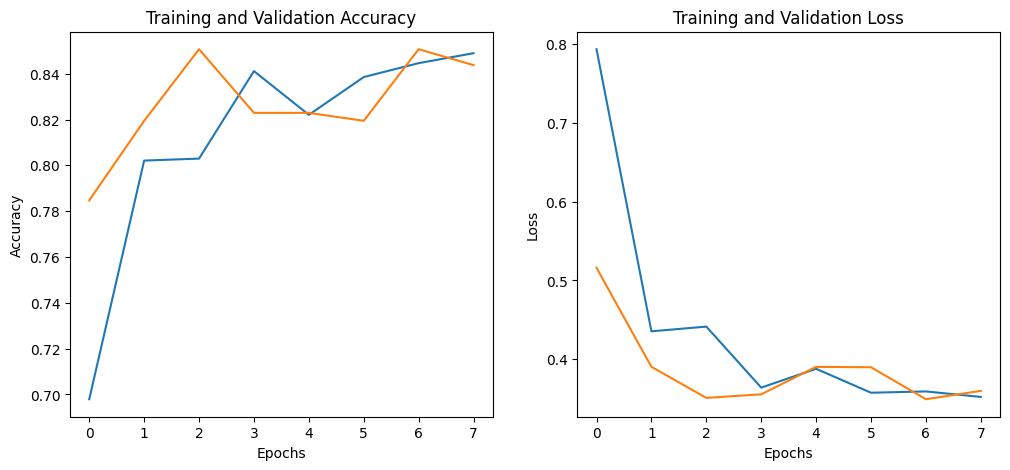

In [16]:
plot_history(history)

In [17]:
model.evaluate_generator(val_data)

C:\Users\admin\AppData\Local\Temp\ipykernel_3628\3807241483.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(val_data)


[0.3282493054866791, 0.856930136680603]